# Анализ крупного интернет-магазина. A/B-тест.

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

__Часть 1.__

- Приоритизируйте гипотезы.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

__Задача__

•	Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

•	Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

•	Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

__Часть 2.__
- Запустите A/B-тест и проанализируйте результаты. 

Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

__Открытие файла и предоброботка данных.__

In [1]:
# импорт библиотек

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
import scipy.stats as stats
import math as mth
from scipy import stats as st

In [2]:
# параметры визуализации
sns.set(
    font_scale =2,
    style      ='whitegrid',
    rc         ={'figure.figsize':(20,7)}
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# Откроем файлы с данными и сохраним их в соответствующие переменные, укажим расширение отображения ячеек таблицы
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('max_colwidth', 150) 

hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [5]:
# чтение файлов с данными
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Изучим таблицы, и подготовим данные к анализу

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
#проверим на дубликаты
hypothesis.duplicated().sum()

0

In [8]:
#приведем названия стобцов к нижнем регистру
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице в колонке date не верный тип. Необходимо привести в нужный

In [10]:
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [12]:
#проверим на дубликаты
orders.duplicated().sum()

0

In [13]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [14]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице в колонке date не верный тип. Необходимо привести в нужный

In [15]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [17]:
#проверим на дубликаты
visitors.duplicated().sum()

0

Открыли все файлы, дубликатов ни в одном не было обноружено. В двух таблицах поправили названия колонок, привели к нижнему регистру, и добавили разджелитили между словами.

 Определим минимальные и максимальные даты в каждой таблице

In [18]:
def dates(x):
    display(x.date.min())
    display(x.date.max())

In [19]:
dates(orders)

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [20]:
dates(visitors)

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Изучим общее колличество заказов в группах, а так же определим количество уникальных пользователей. А так же посмотрим, какое количесвто уникальных пользователей попало одновременно в обе группы.

In [21]:
orders.groupby('group').agg({'transaction_id' : 'count'})

,transaction_id
group,
A,557
B,640


In [22]:
orders.groupby('group').agg({'visitor_id' : 'nunique'})

,visitor_id
group,
A,503
B,586


In [23]:
unique_visitors = orders.loc[:, ['visitor_id', 'group']].drop_duplicates().drop(columns=['group'])
unique_visitors.visitor_id.duplicated().sum()

58

# __Часть 1.__

- Приоритизируйте гипотезы.

__Задача 1__

 __- Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.__

In [24]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
round(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).head(9), 2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


__- Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.__

In [25]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).head(9)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


__Вывод__

Наиболее перспективные гипотезы по ICE:  \
8 - Запустить акцию, дающую скидку на товар в день рождения;  \
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;	  \
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.  \

Наиболее перспективные гипотезы по RICE: \
7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;  \
2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;	\
0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;  \
6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.	\


Приоритизация разная, потому, что формулы разные, одна учитывает охват (RICE), а другая — нет (ICE). У ICE и RICE отличается формула одним параметром. И если этот параметр у гипотезы большой, то и RICE будет выше соответственно. Параметр Reach помогает нам понять, скольких пользователей затронет гипотеза.

# __Часть 2.__

- Анализ A/B-теста.

__Задача 2.__
__Проанализируйте A/B-тест:__

__-Построем график кумулятивной выручки по группам. Сделаем выводы и предположения.__

In [26]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

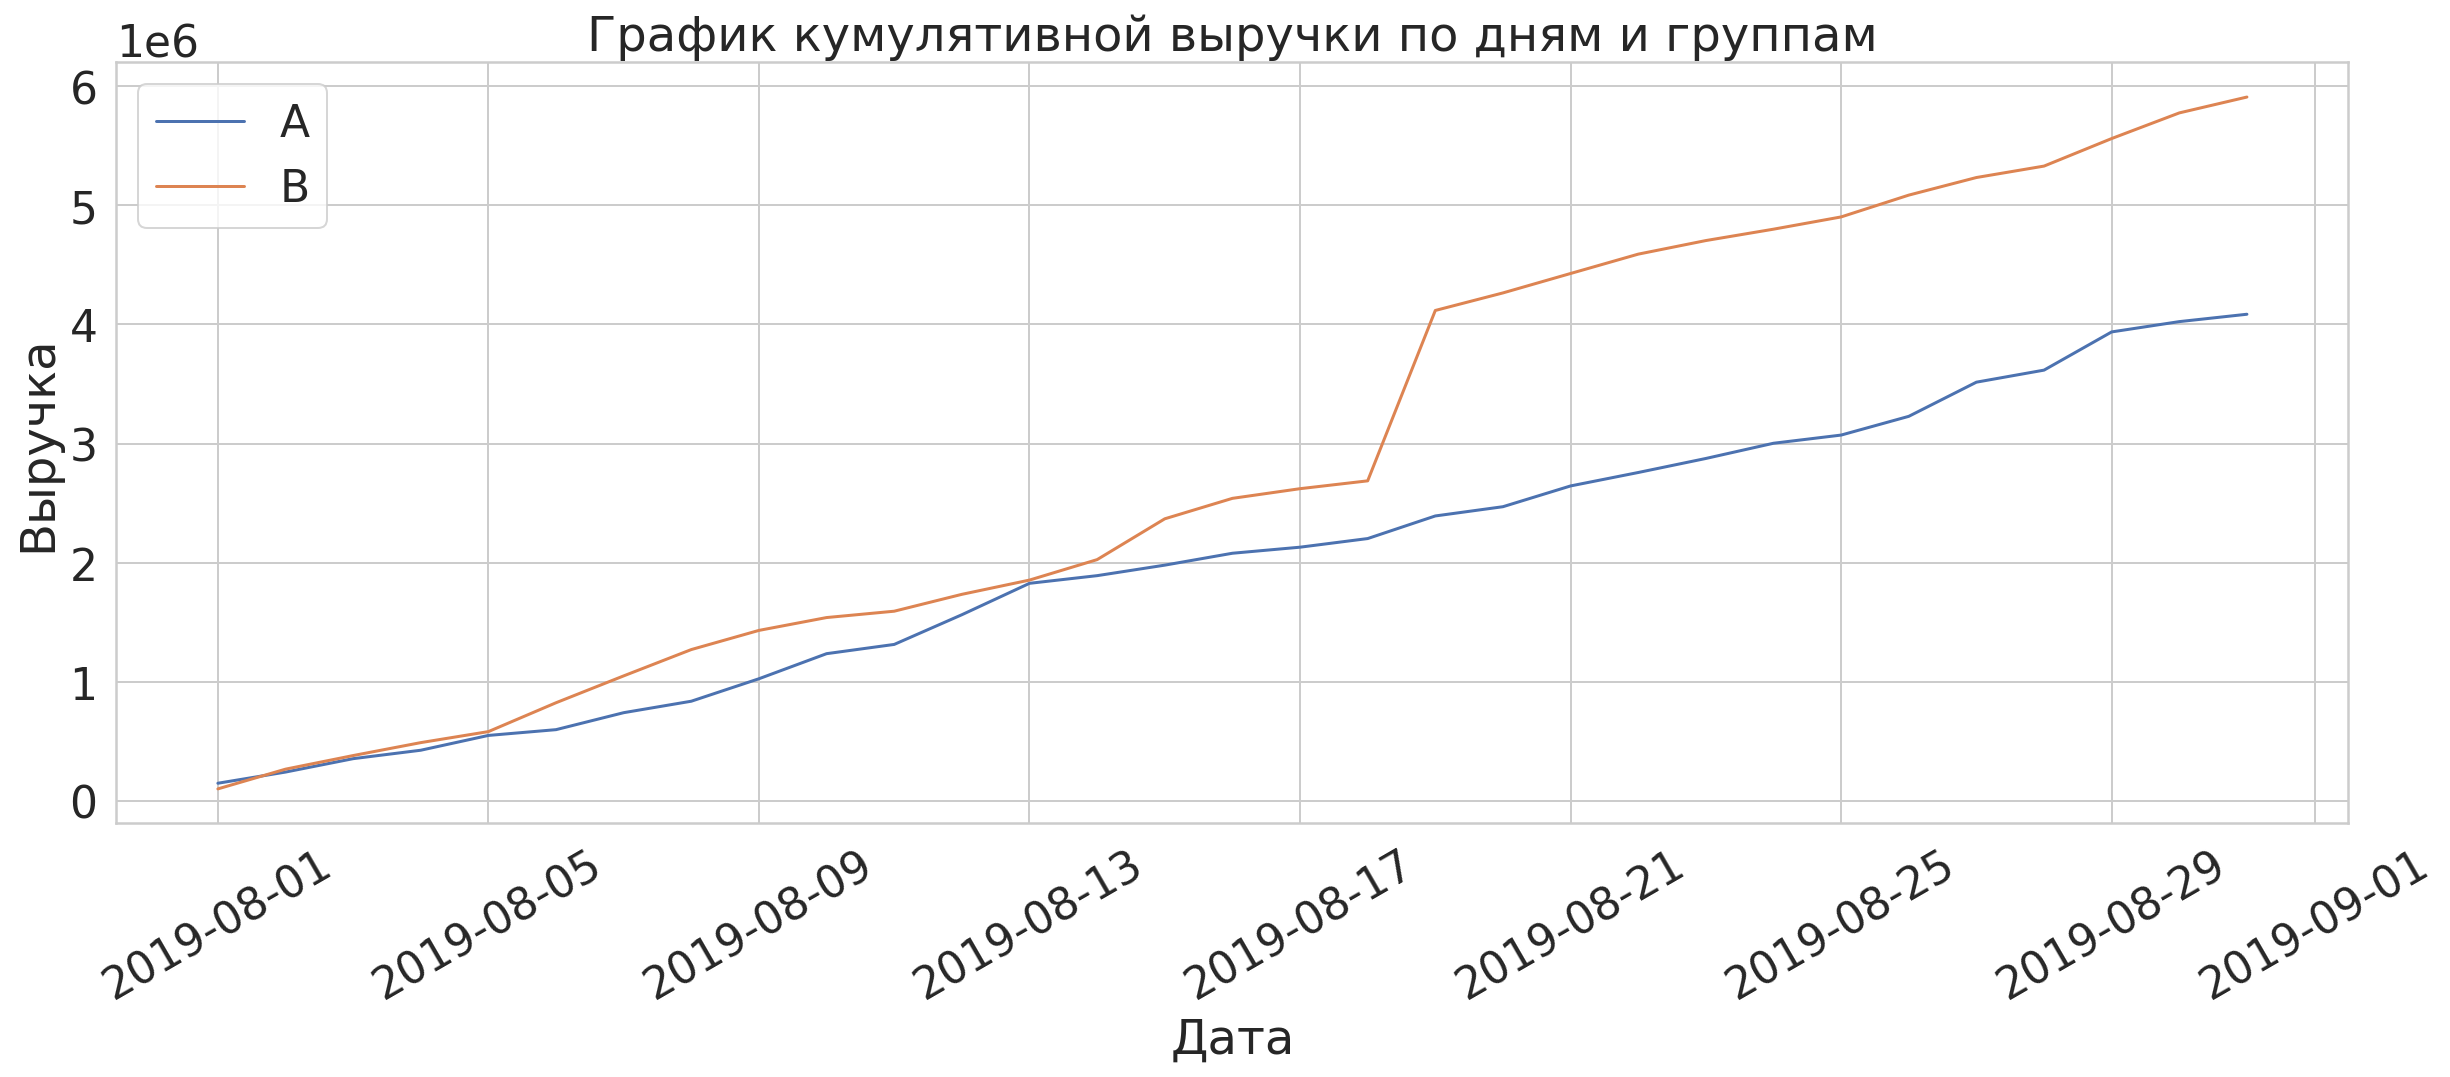

In [27]:
# создание датафрейма datesGroups с уникальными парами значений 'date' и 'group', таблицы orders; удаление дубликатов
datesGroups = orders[['date', 'group']].drop_duplicates()


ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', # дата
            'group': 'max', # группа A/B-теста
            'transaction_id': 'nunique', # число уникальных заказов в группе теста по указанную дату включительно
            'visitor_id': 'nunique', # число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста
            'revenue': 'sum', # суммарная выручка заказов в группе теста по указанную дату включительно
        }
    ),
    axis=1,
).sort_values(by=['date', 'group']) # сортировка по столбцам 'date', 'group'


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# определение переменной по колонкам 'date', 'group' методом merge()
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

# присвоение столбцам cumulativeData названия
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


# переменная с данными о датах, выручке и числе заказов в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]

# переменная с данными о датах, выручке и числе заказов в группе В
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]
plt.title('График кумулятивной выручки по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=30)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()

С начала теста, 5 дней выручка равномерно увеличивается в обоих сегментах. Где-то с 18-го числа сигмент B резко вырвался вперёд и продолжил лидировать весь остаток теста, можно предположить, что это связано с ростом количества заказов или же с покупками дорогостоищих товаров. Стоит отметить, что сегмент A растет достаточно равномерно, на протяжении всего теста.

__-Построем график кумулятивного среднего чека по группам. Сделаем выводы и предположения.__

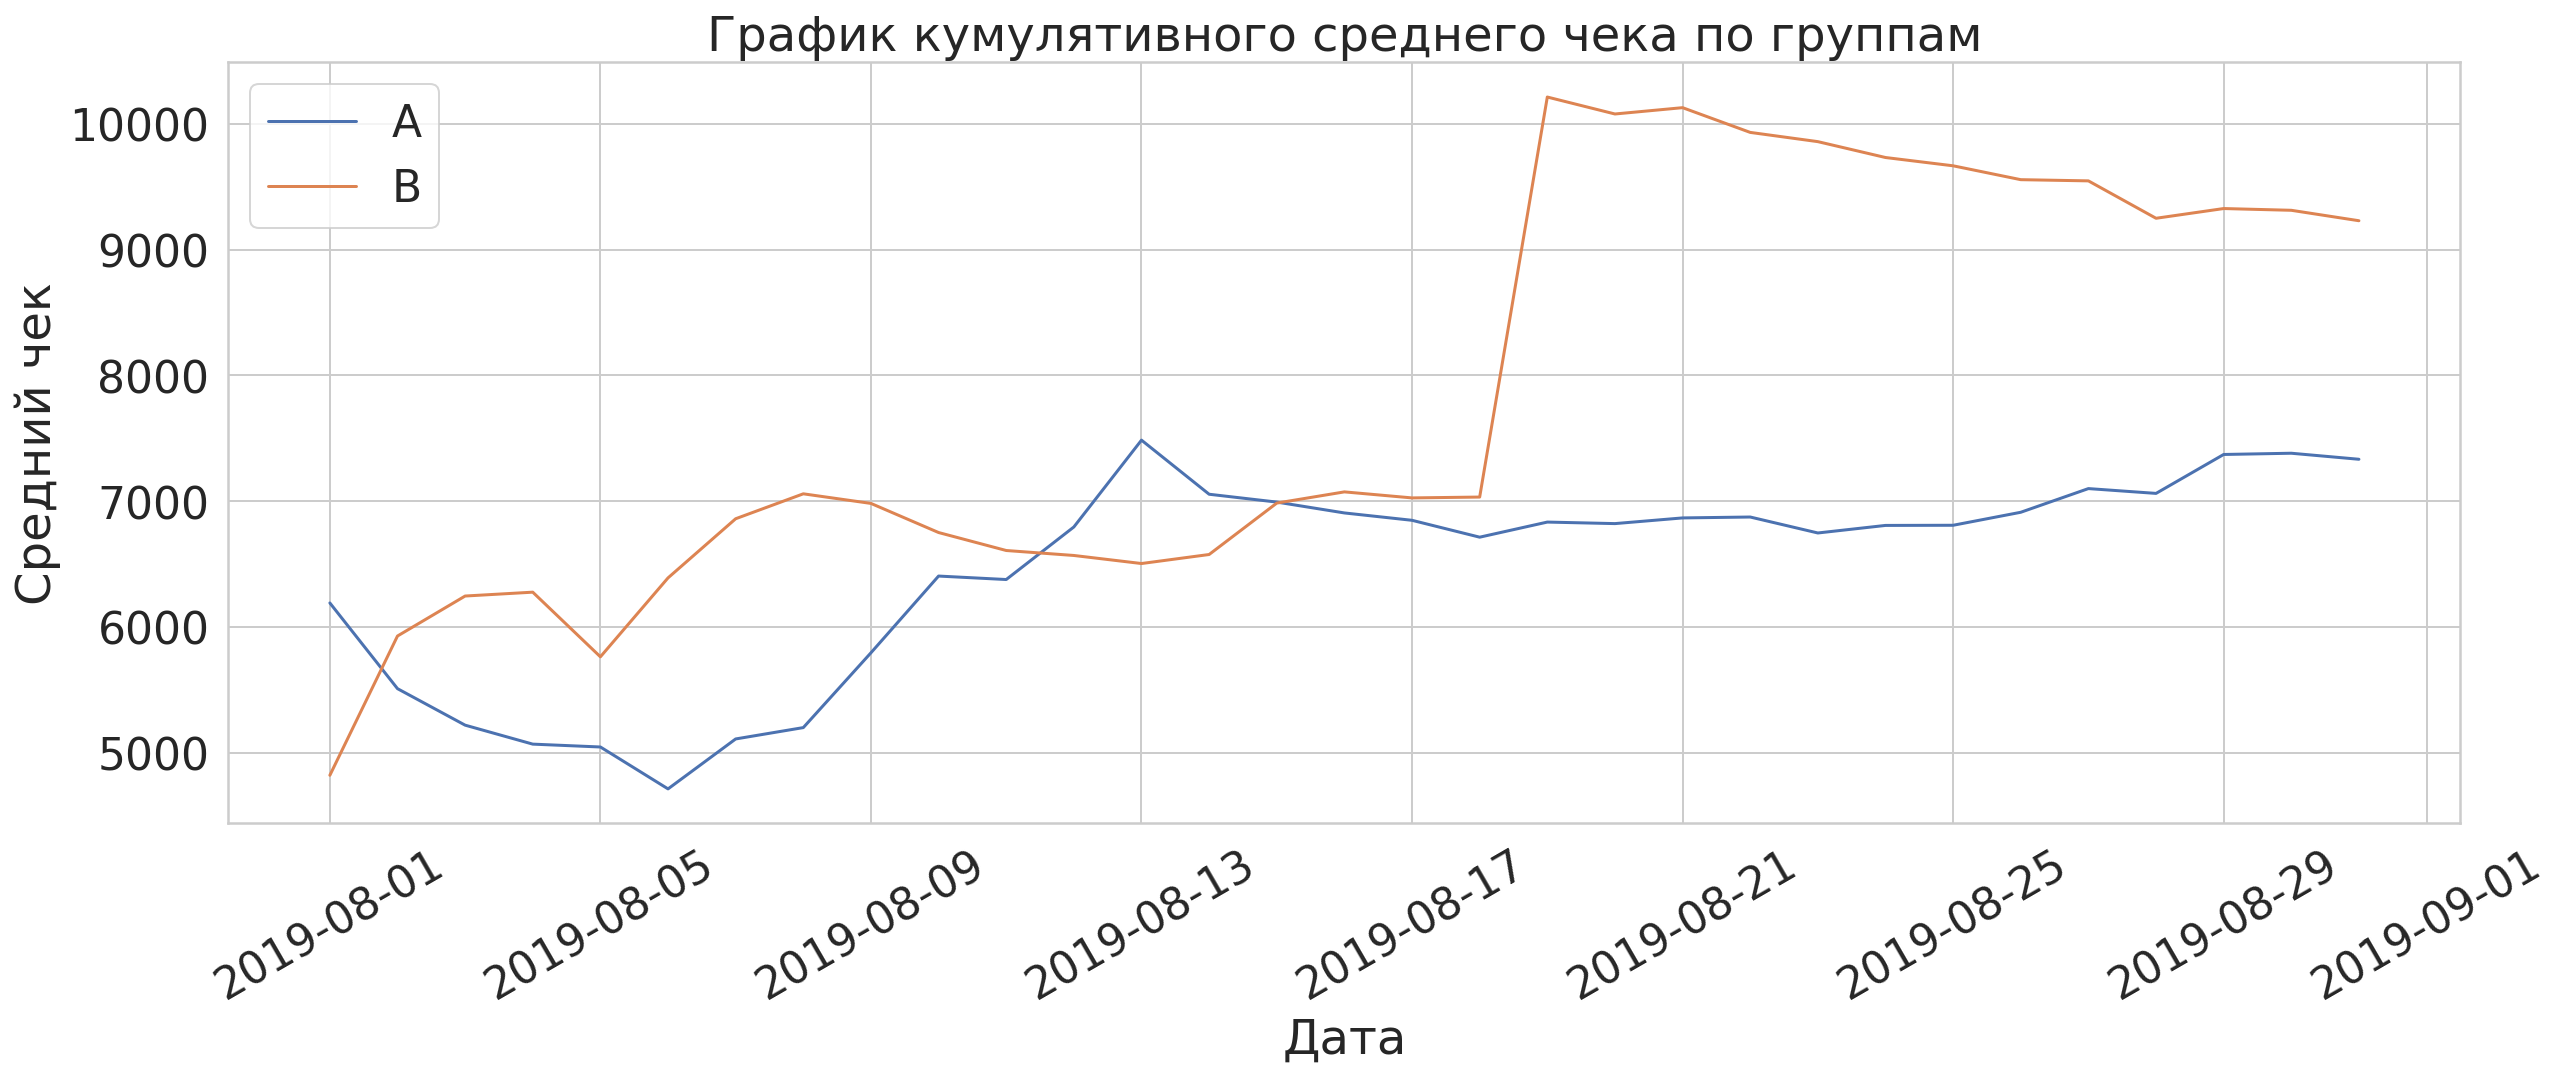

In [28]:
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=30)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

Кумулятивное значение среднего чека в группе B с 18-го числа резко выросло, и к концу теста начинает плавно снижаться,как и отмечалось ранее, скорее всего это связано с покупкой дорогостоющих товаров. Группа A имела как падения, так и взлеты, но все это без резких, выдающихся колебаний, идет плавно, и к концу теста растет.

__-Построем график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.__

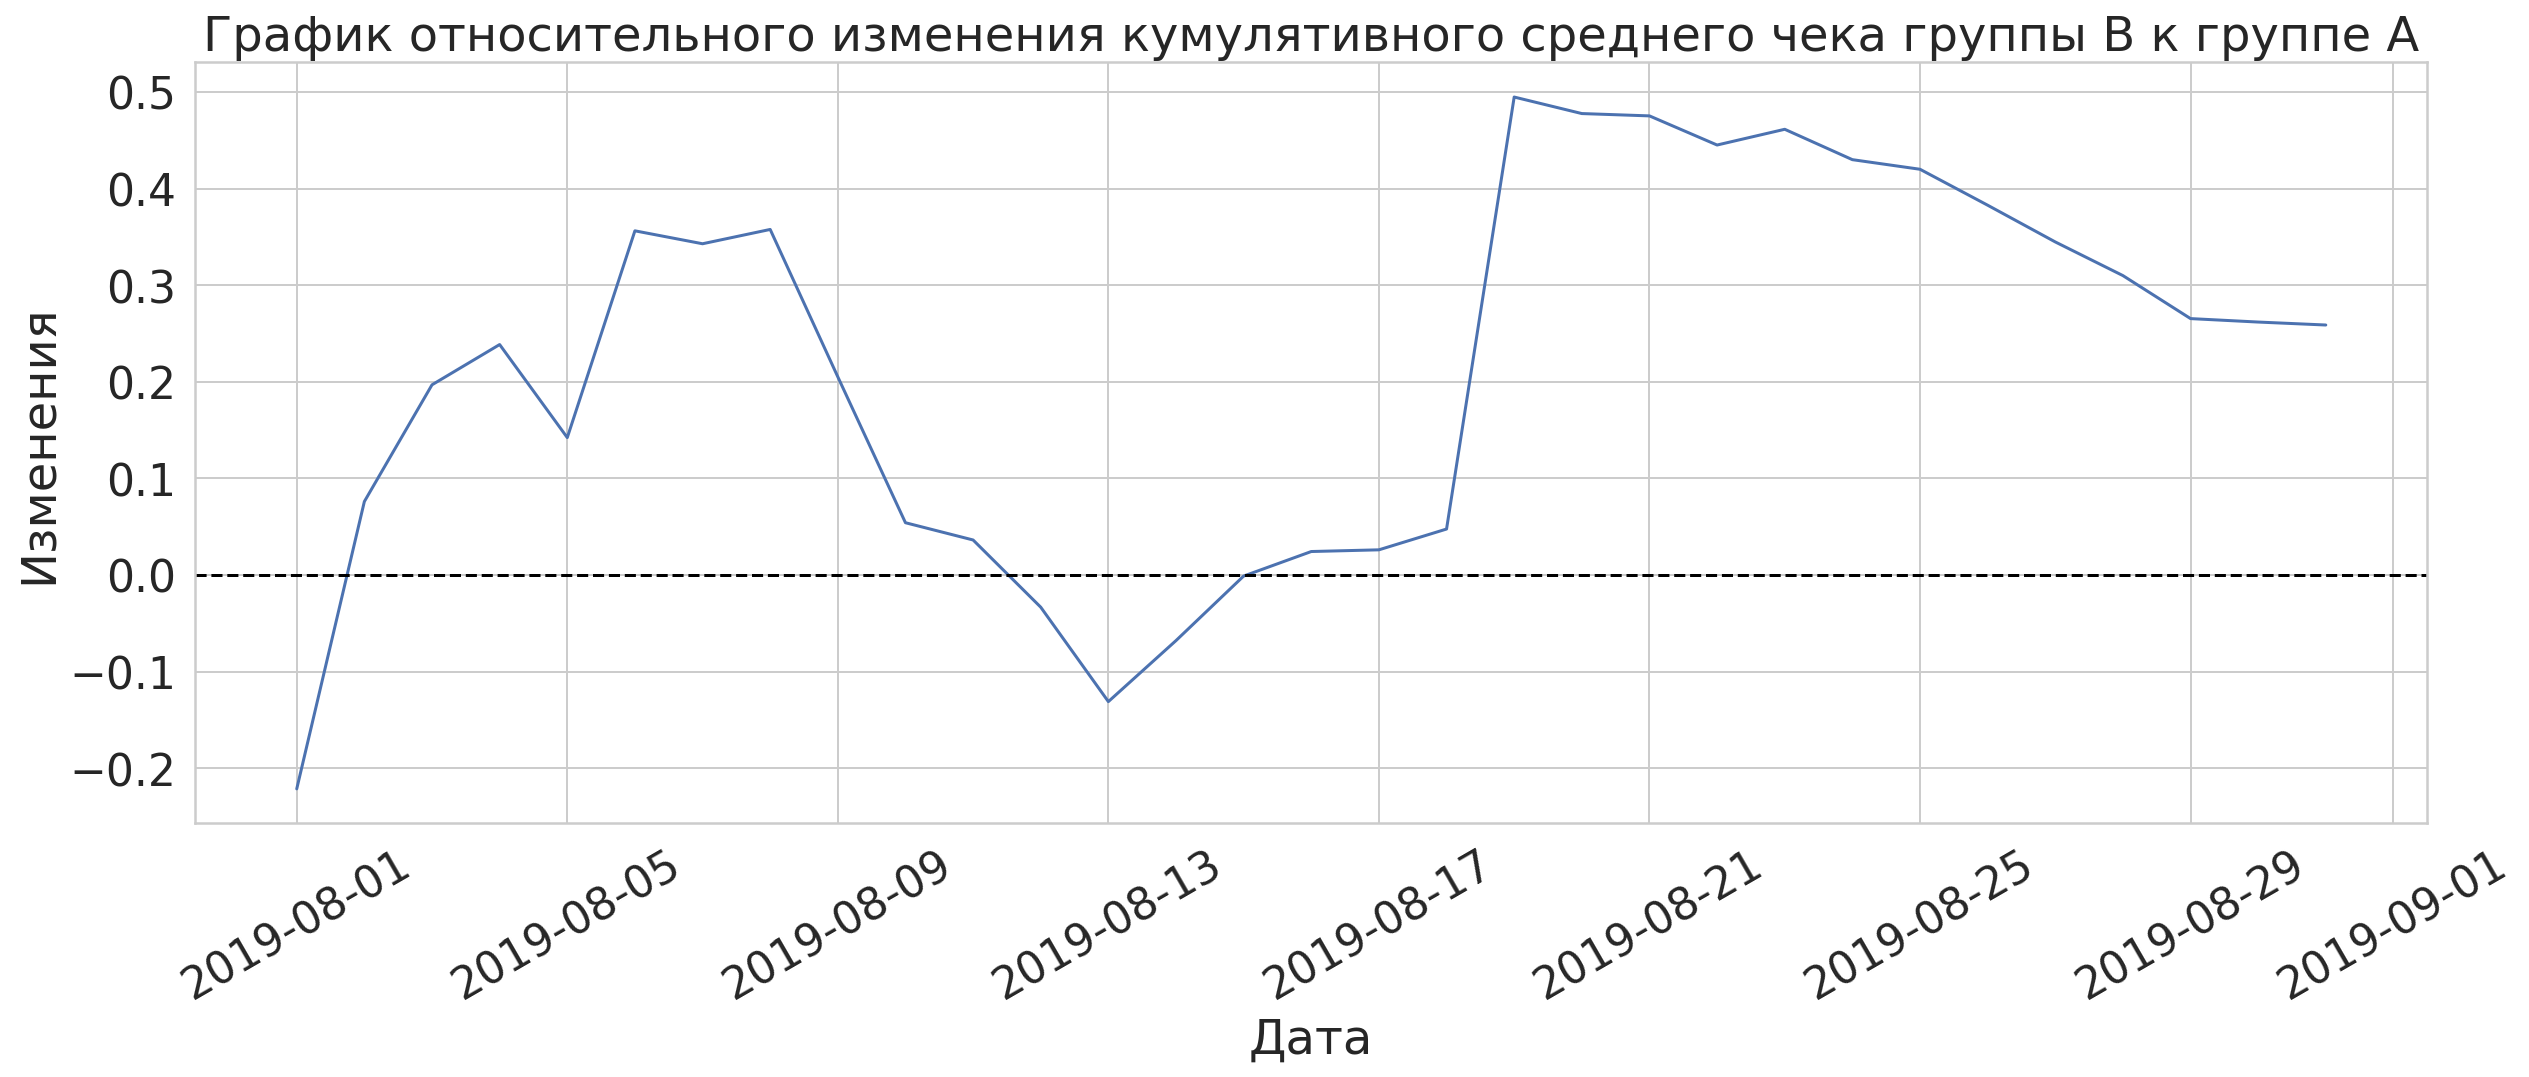

In [29]:
mergedCumulativeRevenue  = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                    left_on='date', 
                                                    right_on='date', 
                                                    how='left', 
                                                    suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], 
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1);

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменения')
plt.xticks(rotation=30)
plt.axhline(y=0, color='black', linestyle='--')

Построили график относительного различия в среднем чеке между группами. Результаты теста значительно и резко менялись в несколько дат.Видимо, именно тогда были совершены крупные заказы.

__-Построем график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.__

Text(0, 0.5, 'Конверсия')

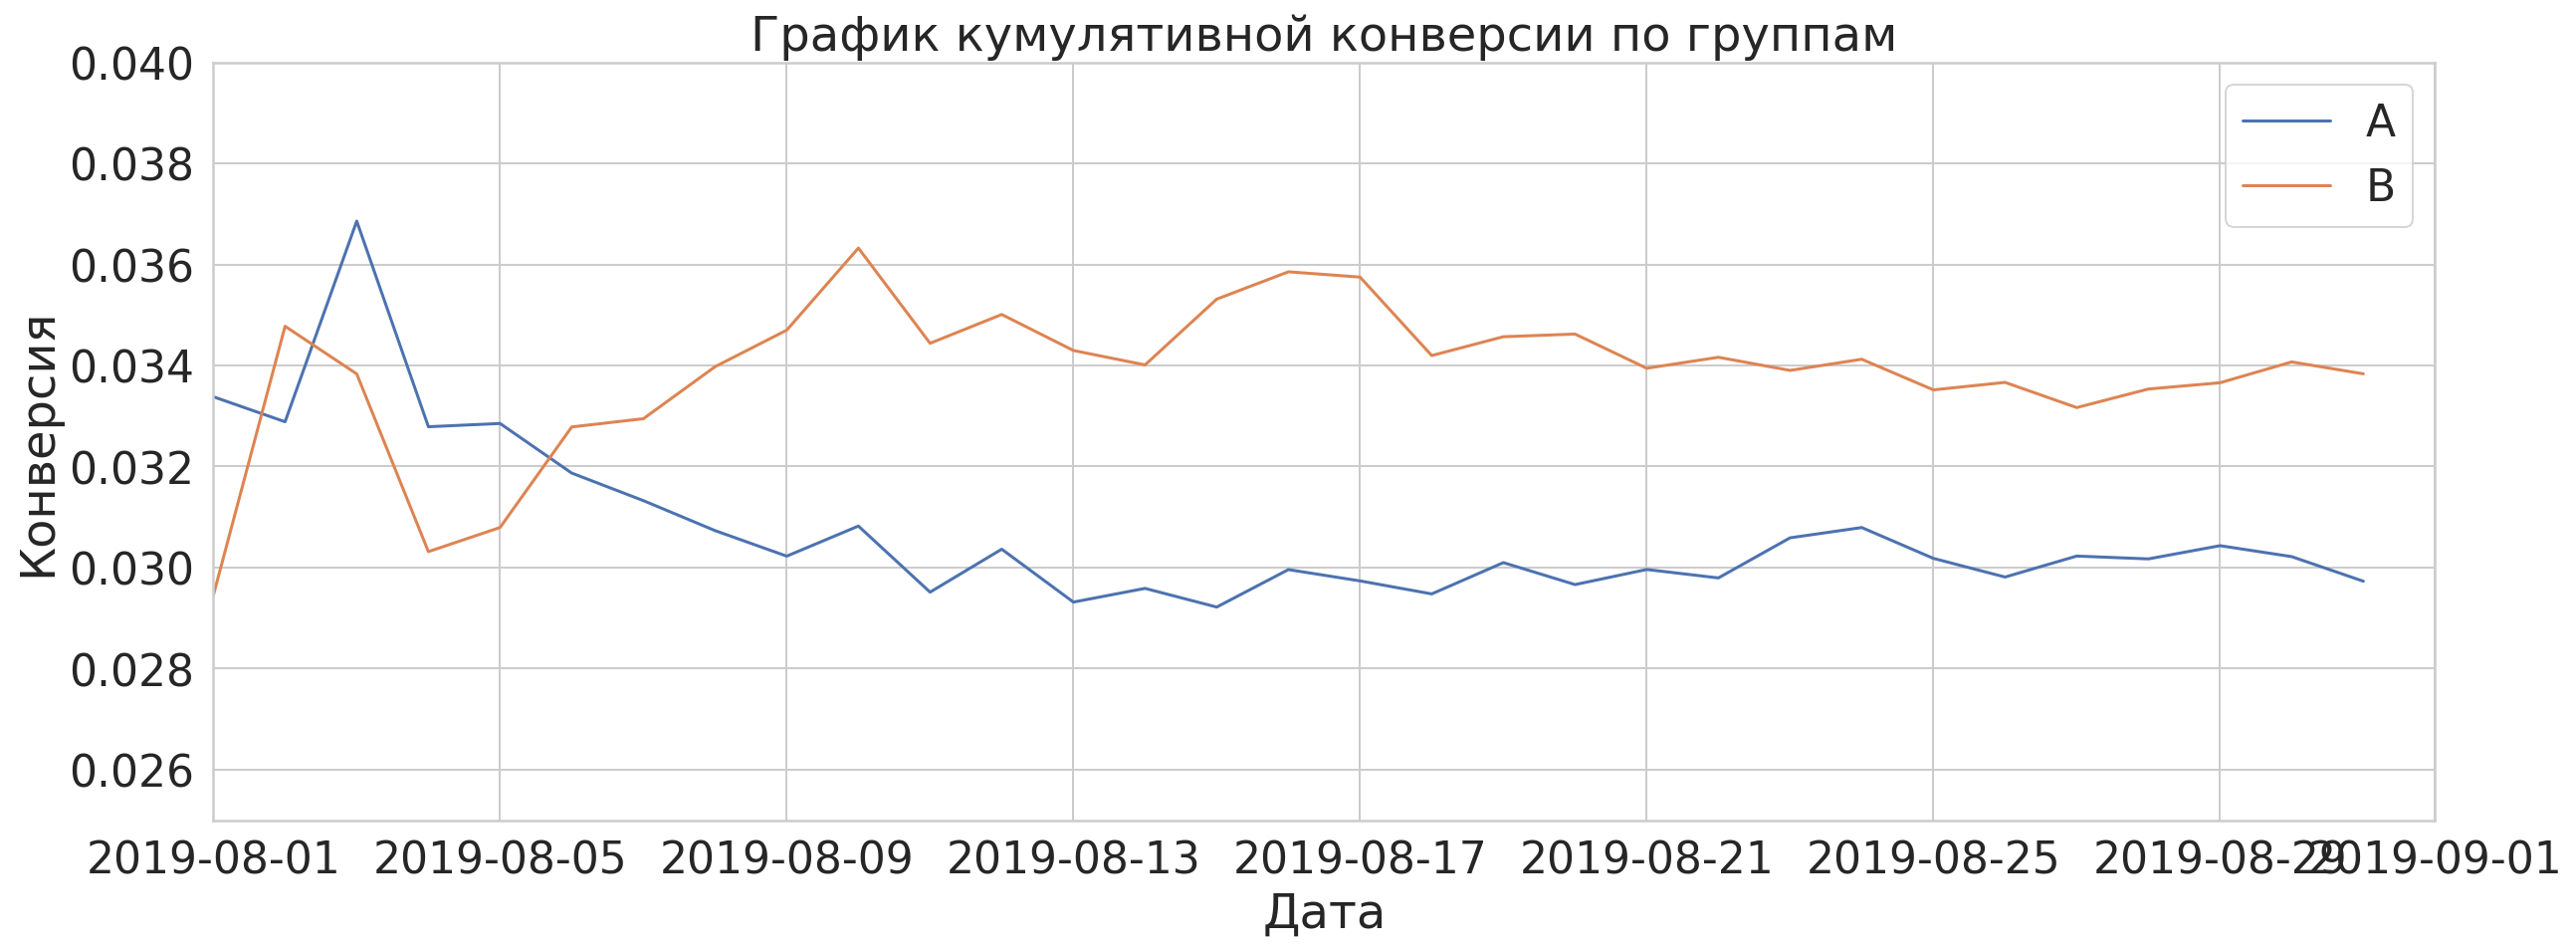

In [30]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.025, 0.04])

plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')

В начале теста группа А имела большую конвкрсию, но с 6-го числа группа В выровнялась и начала расти. Группа А с 9-го числа далее идет относительно равномерно, и как итог группа А с начала теста имела конверсию - 3,3%, к концу теста 2,9%. Группа В на начало теста 2,9%, на конец 3,3%. Можно сделать вывод, что конверсия группы В оказалась лучше.

__-Построем график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.__

Text(0, 0.5, 'Изменения')

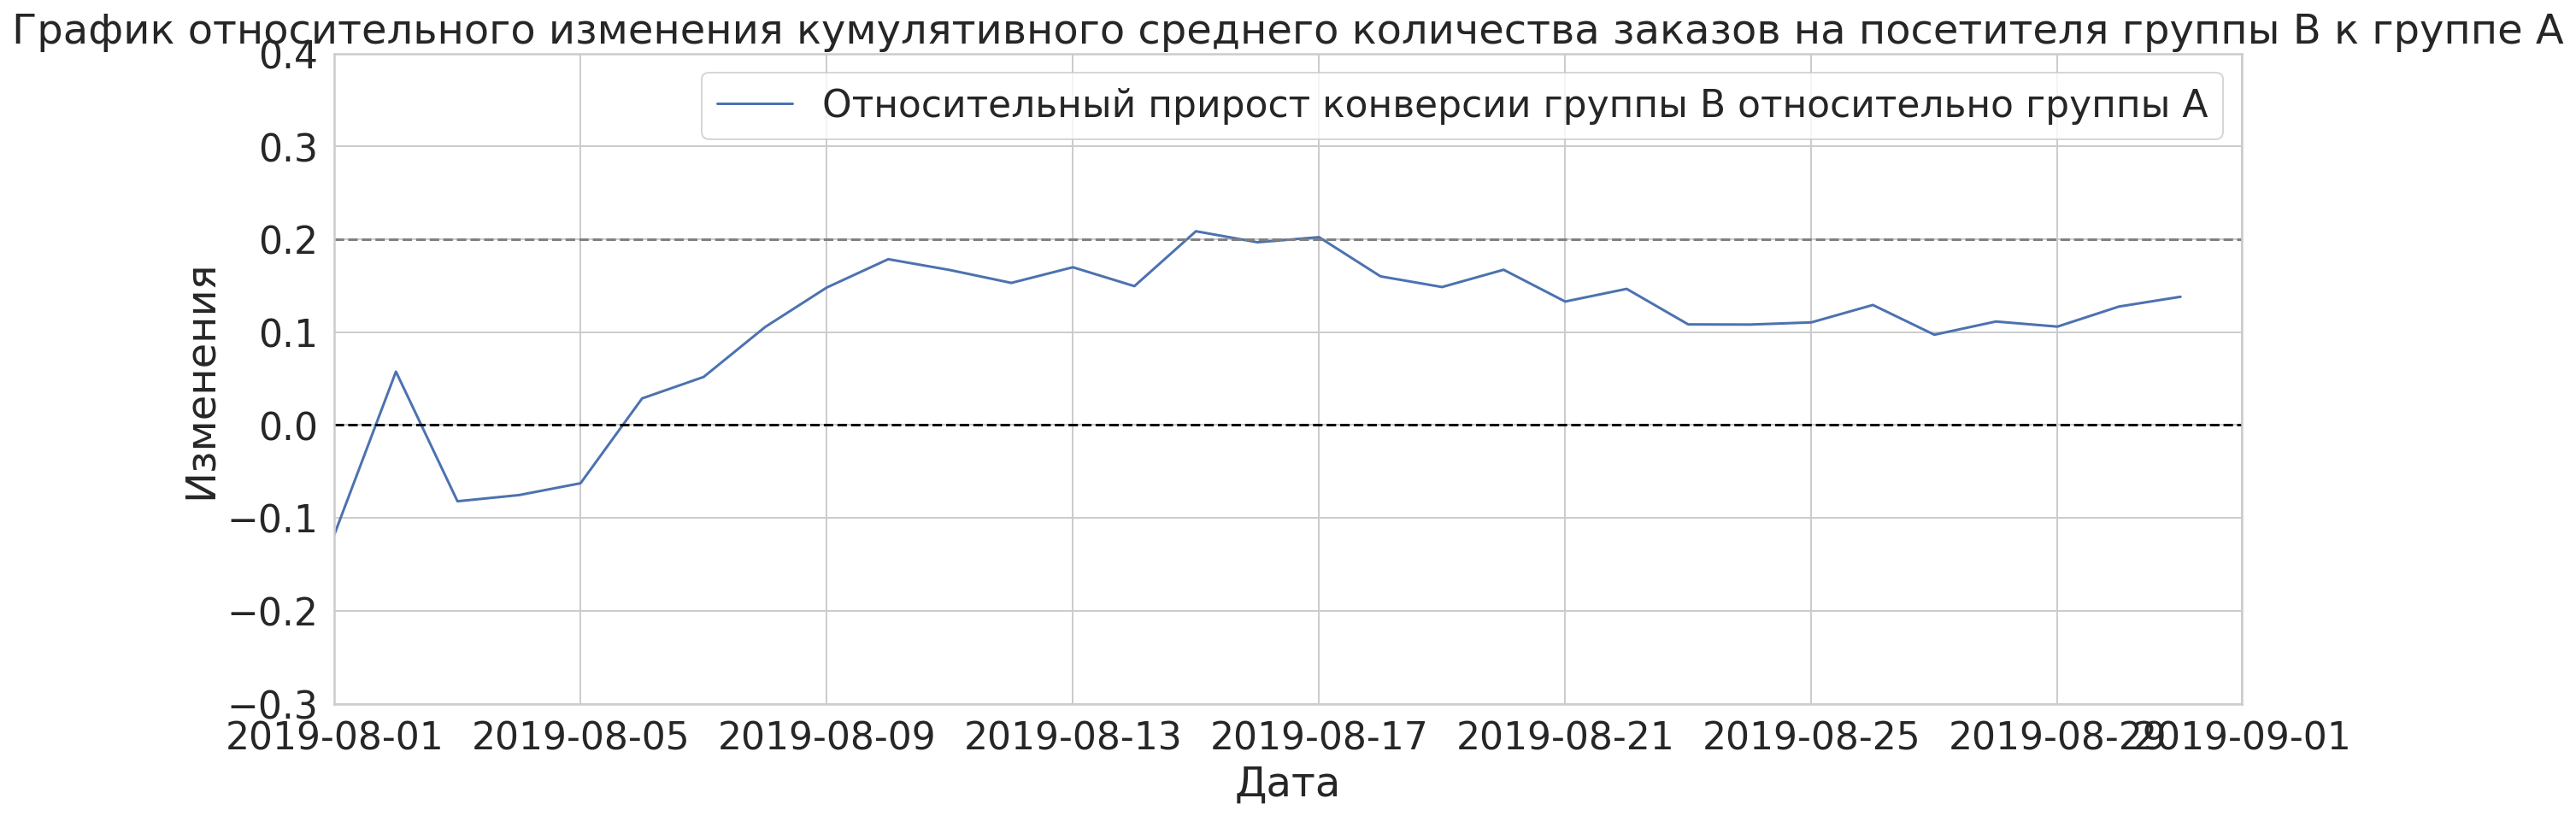

In [31]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.3, 0.4])
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменения')

Почти с самого начала теста группа В лидирует по конверсии: становится лучше и лучше, с 15-го числа и до 17-го зафиксировалась в приросте 20%, но с 17.08  начала падать, вплоть до 22.08 - наименьшая точка в этот отрезок времени была чуть меньше 10%. И начиная с 23.08 доконца теста вновь пошла на рост.

__-Построем точечный график количества заказов по пользователям. Сделаем выводы и предположения.__

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Text(0, 0.5, 'Количество заказов')

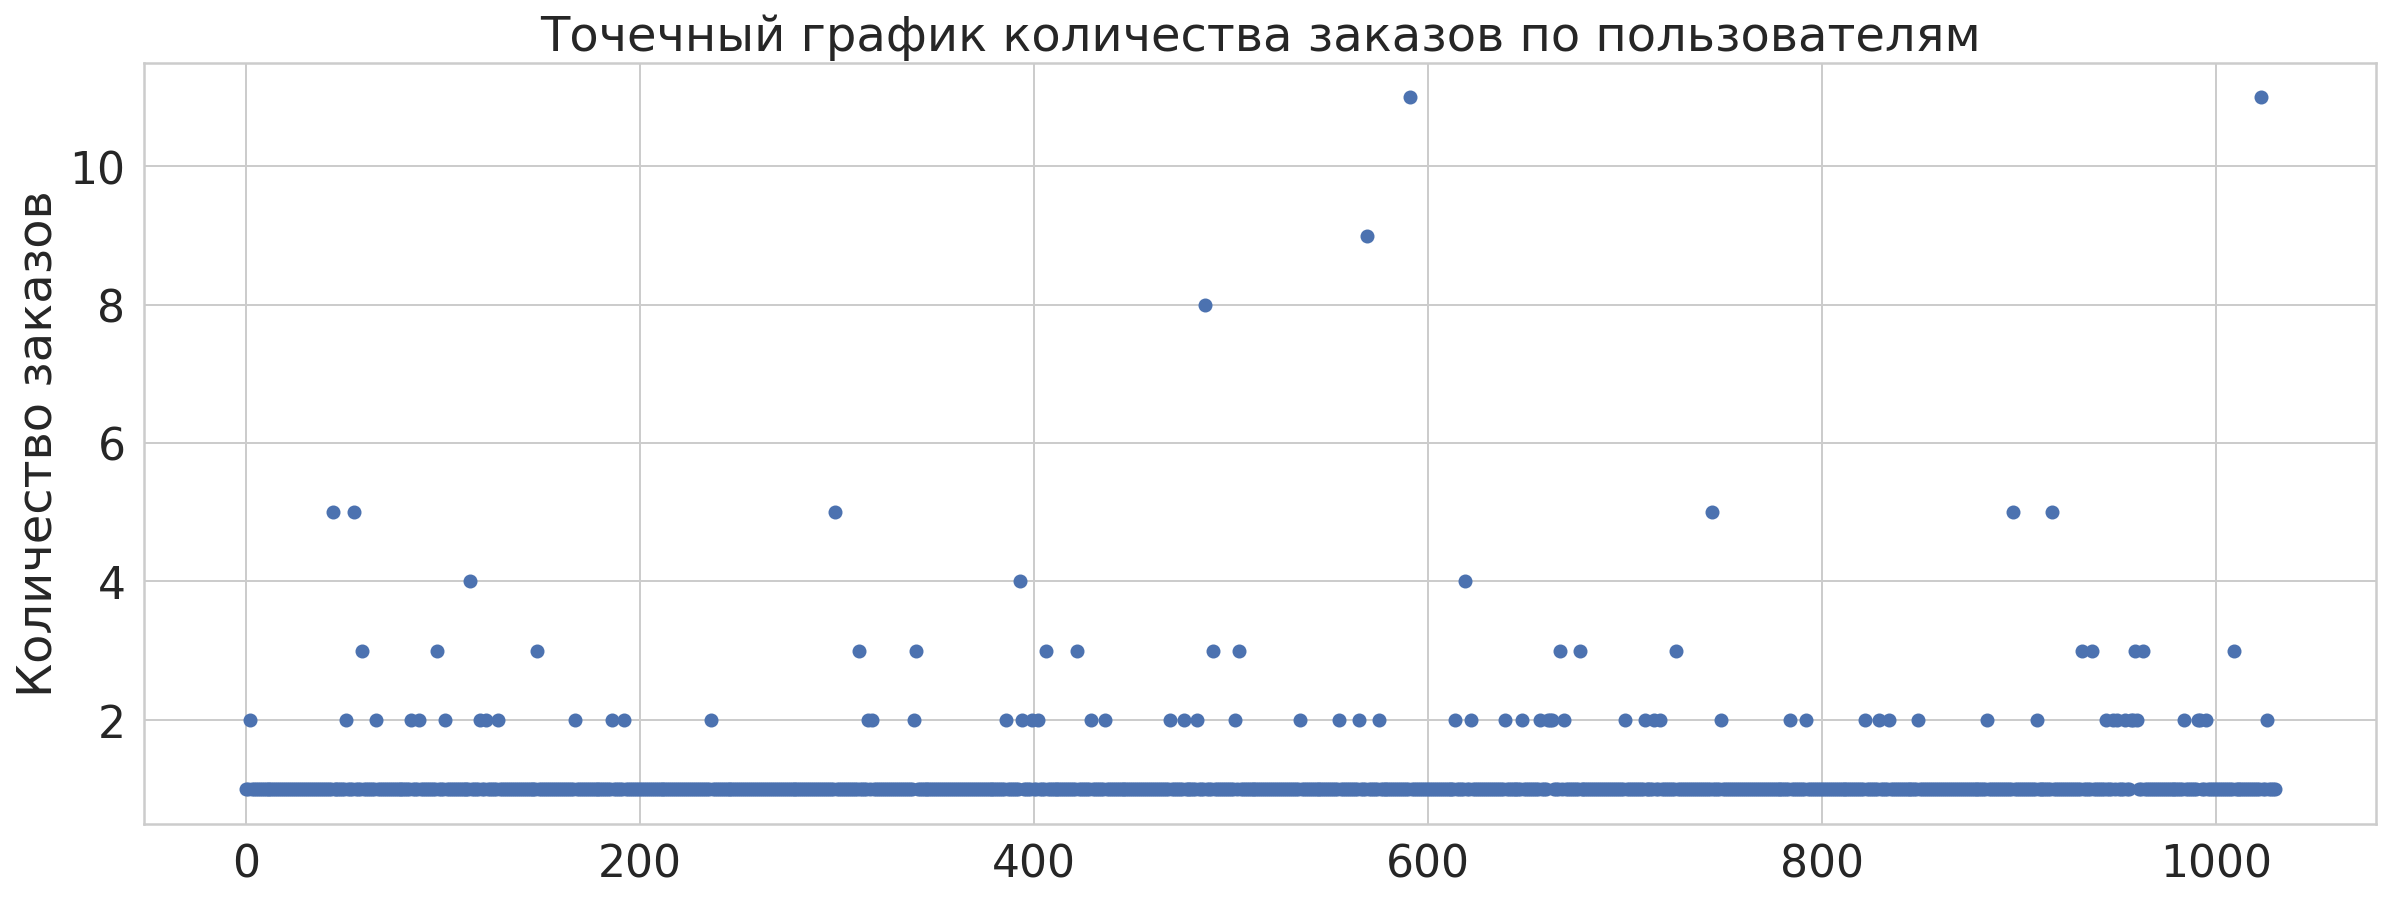

In [32]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']);

plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество заказов')

Пользователей заказавших более 2-х раз мало. Согласно графика, имеется определенное количесвто клиентов сделавших заказа 2 раза. Чтобы понять, много это или мало, необходимо посчитать выборочные перцентили.

__-Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей.__

In [33]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей - больше 4 заказов. Соответственно, за нижнюю границу числа заказов необходимо выбрать 2 заказа на одного пользователя , и отсеять аномальных пользователей по ней.

__-Построем точечный график стоимостей заказов. Сделаем выводы и предположения.__

      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  1294500     B
1196      3936777065  2108080724 2019-08-15   202740     B
858        192721366  1316129916 2019-08-27    93940     A
1136       666610489  1307669133 2019-08-13    92550     A
744       3668308183   888512513 2019-08-27    86620     B
682       1216533772  4266935830 2019-08-29    78990     B
662       1811671147  4266935830 2019-08-29    78990     A
743       3603576309  4133034833 2019-08-09    67990     A
1103      1348774318  1164614297 2019-08-12    66350     A
1099       316924019   148427295 2019-08-12    65710     A


Text(0, 0.5, 'Стоимость заказа в млн ед.')

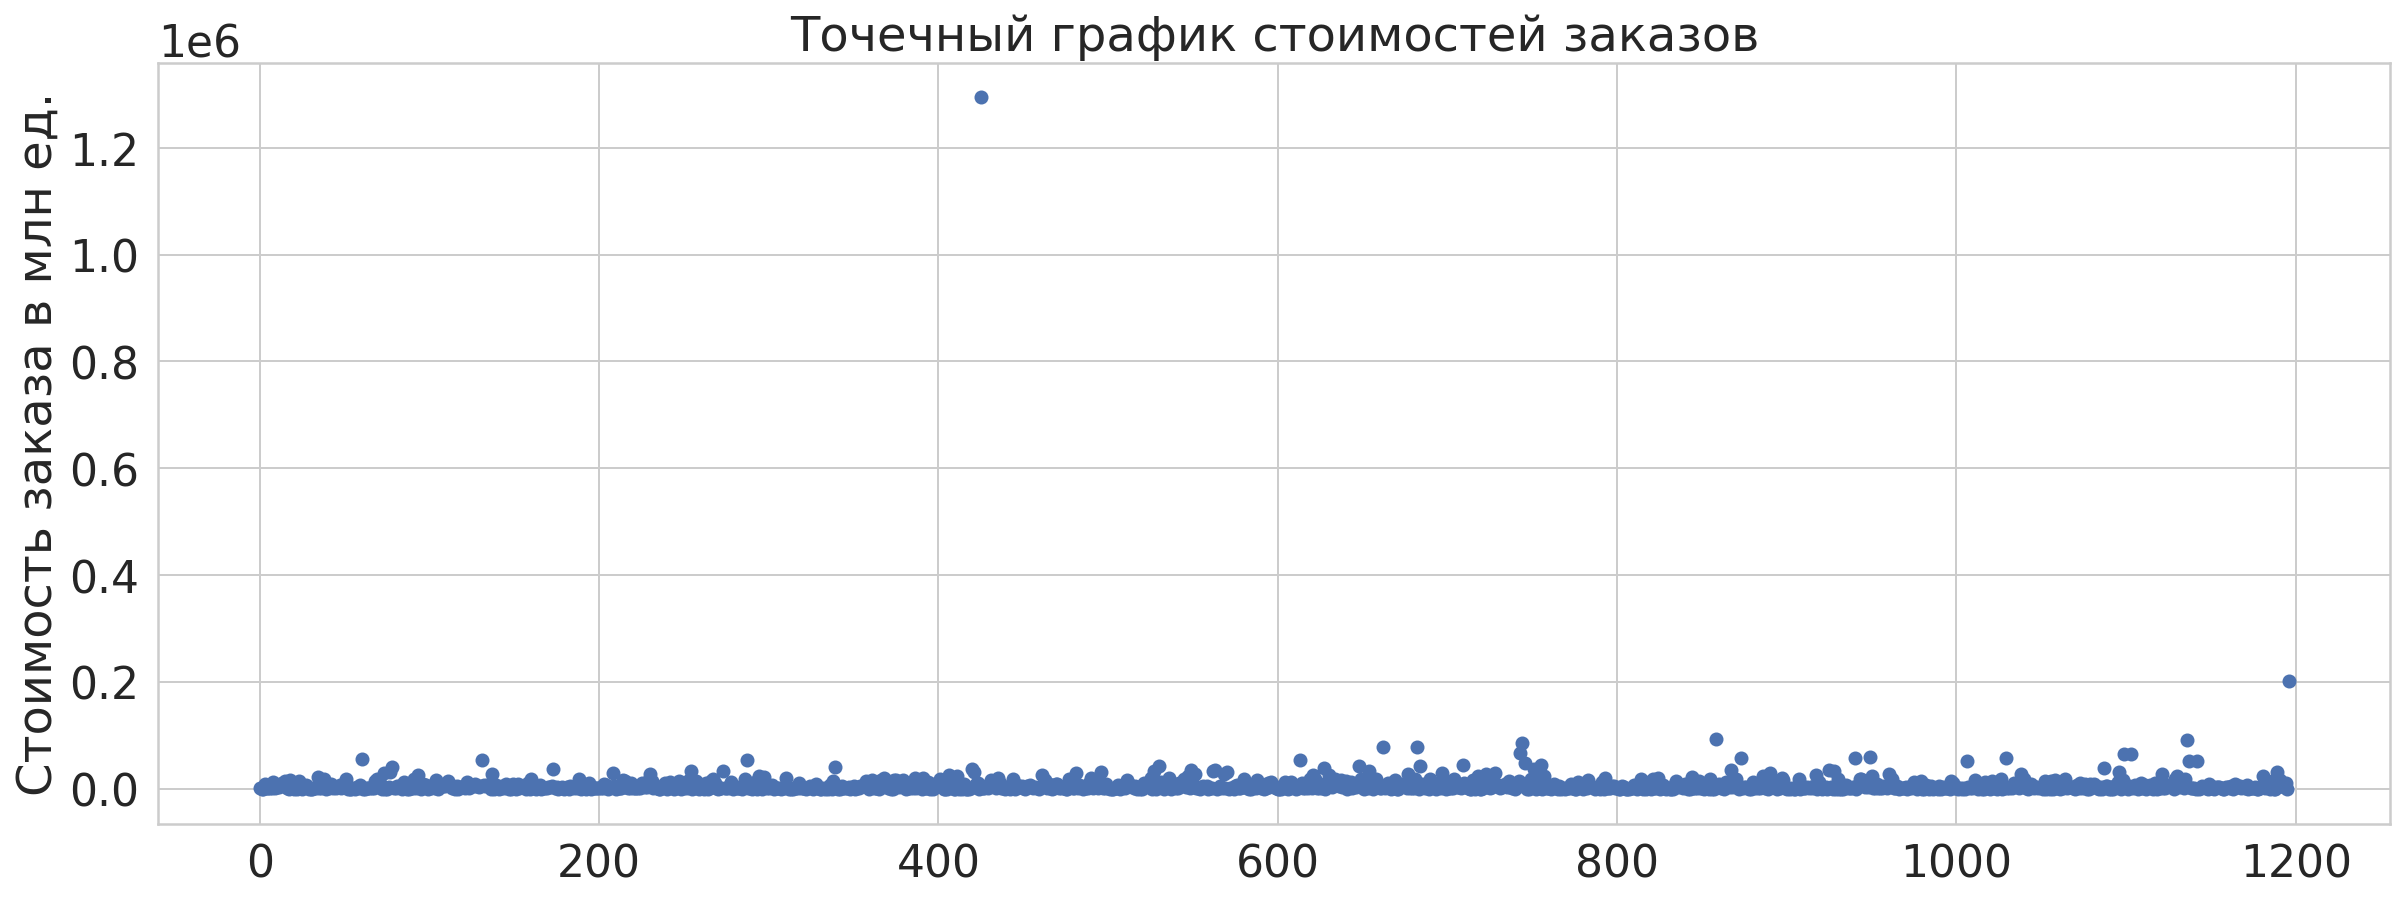

In [34]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']);
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа в млн ед.')

Согласно графика, был сделан 1 самый крупный заказ - более 1,2 млн.ед., данный заказ выбивается из общей массы и выглядит аномальным. Так же выделяется заказ суммой около 200 000. Все остальные заказы распалагаются равномерно.

__-Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.__

In [35]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% пользователей чек дороже 28 тыс. ед. Не больше, чем у 1% - дороже 58 233,2 ед. Соответтственно граница для определения аномальных заказов определим - 28 тыс. ед.

__-Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.__

H_0: различий в конверсии между группами нет.\
H_1: различия в конверсии между группами есть.\
alpha = 0.05

In [36]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

# для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['user_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['user_id', 'orders'] 

# пользователям с заказами будет соответствовать число заказов пользователя, а пользователям без заказов — нули
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("p-value -","{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост конверсии группы В:","{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value - 0.01679
Относительный прирост конверсии группы В: 0.138


p-value значительно меньше 0.05, и равен 0.01679, потому нулевую гипотезу отвергаем. Относительный прирост конверсии группы В к конверсии группы А равен 13,8%.

__Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.__

H_0: различий в среднем чеке между группами нет.\
H_1: различия в среднем чеке между группами есть.\
alpha = 0.05

In [37]:
print('p-value','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между группами','{0:.3f}'.format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue']
                       .mean()-1)) 

p-value 0.729
Относительное различие среднего чека между группами 0.259


p-value больше 0.05 - статистически значимых отличий в среднем чеке между группами нет. Относительное различие среднего чека между группами составило 25,9%. \
Нулевая гипотеза не отвергается.

__-Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.__

In [38]:
# срезы пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id'],
    ],
    axis=0,
)

# срезы пользователей
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value -','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии группы В:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value - 0.01304
Относительный прирост конверсии группы В: 0.173


Как и в случае с сырыми данными, статистическая значимость достигнута. Группа В значительно лучше (на 17%) группы А - показатель даже выше, в сравнении с "сырыми" данными.

__-Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.__

In [39]:
print('p-value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное различие среднего чека между группами',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value 0.738
Относительное различие среднего чека между группами -0.020


Показатель p-value оказался приблезительно такой же как и в "сырых" данных. Т.е. нулевую гипотезу мы не отвергаем. Средний чек группы В стал меньше группы А, заказы с дорогостоящими покупками все же повлияли на результаты теста.

__- Примим решение по результатам теста и объясним его.__

# Остановить тест, зафиксировать победу одной из групп. 

На основании проведенного исследования, имеем следующие результаты.\
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. \
- Статистически значимых различий по среднему чеку не были зафиксированы в обоих случаях.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.\
- График различия среднего чека колеблется: что свидетельствует о наличии аномалиий.

__Тест остановить, зафиксировать победу за группой В. Конверсия группы B выше группы A на 13,8% (по "сырым" данным) и 17% (по очищенным даным). Предполагается, что с увеличением конверсии будет увеличиваться средний чек.__